# Querying On-Disk Tables

> Objectives:
> * Compare queries of tabular data for **on-disk** containers
> * Compare sizes and times for those

In [1]:
if 'MemWatcher' not in dir():
    from ipython_memwatcher import MemWatcher
    mw = MemWatcher()
    mw.start_watching_memory()

In [1] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 43.316 MiB


## Load movielens datasets in pandas DataFrames

Let's start loadind dataset in pandas so that we can create persistent versions more easily later on.

In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 43.316 MiB


In [3]:
# Import CSV files via pandas
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 70.508 MiB RAM in 0.444s, peaked 8.219 MiB above current, total RAM usage 113.824 MiB


In [4]:
# Store movies and ratings in 2 separate tables in SQLite
sqlite_norm = "movielens-norm.sqlite"
if os.path.exists(sqlite_norm):
    os.unlink(sqlite_norm)
import sqlite3
conn = sqlite3.connect(sqlite_norm)
conn.text_factory = str   # Shut up problems with Unicode
ratings.to_sql("ratings", conn)
movies.to_sql("movies", conn)
conn.close()

In [4] used 25.945 MiB RAM in 2.021s, peaked 235.375 MiB above current, total RAM usage 139.770 MiB


In [5]:
# Create one merged DataFrame
lens = pd.merge(movies, ratings)

In [5] used 84.141 MiB RAM in 0.068s, peaked 0.000 MiB above current, total RAM usage 223.910 MiB


In [6]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [6] used 61.129 MiB RAM in 0.115s, peaked 0.000 MiB above current, total RAM usage 285.039 MiB


In [7]:
# Store lens denormalized in 1 table in SQLite
sqlite_denorm = "movielens-denorm.sqlite"
if os.path.exists(sqlite_denorm):
    os.unlink(sqlite_denorm)
conn_denorm = sqlite3.connect(sqlite_denorm)
conn_denorm.text_factory = str   # Shut up problems with Unicode
lens.to_sql("lens", conn_denorm)
conn_denorm.close()

In [7] used 46.699 MiB RAM in 2.314s, peaked 222.359 MiB above current, total RAM usage 331.738 MiB


In [8]:
# Get rid of unnecessary containers to save memory
del movies, ratings

In [8] used -0.238 MiB RAM in 0.001s, peaked 0.238 MiB above current, total RAM usage 331.500 MiB


In [9]:
%time result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 37.6 ms


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [9] used 0.145 MiB RAM in 0.045s, peaked 0.000 MiB above current, total RAM usage 331.645 MiB


In [10]:
# keep the run-time for reference
qtime_pandas_mem = mw.measurements.time_delta
qtime_pandas_mem

0.045323848724365234

In [10] used 0.039 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 331.684 MiB


## bcolz

`bcolz` cannot only deal with data in-memory, but also on-disk using exactly the same API.  Let's try that.

In [11]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4hc'
bcolz.defaults.cparams['clevel'] = 6
bcolz.defaults.cparams['shuffle'] = bcolz.BITSHUFFLE
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.1.1.dev16
bcolz git info:    b'1.1.0-16-g6a40395'
NumPy version:     1.11.1
Blosc version:     1.9.3 ($Date:: 2016-07-06 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.6.1
Dask version:      0.11.0
Python version:    3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux-x86_64
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


8

In [11] used 8.832 MiB RAM in 0.067s, peaked 0.000 MiB above current, total RAM usage 340.516 MiB


In [12]:
# Import a pandas DataFrame in a ctable on-disk
bcolz_dir = "movielens-denorm.bcolz"
if os.path.exists(bcolz_dir):
    import shutil
    shutil.rmtree(bcolz_dir)
zlens = bcolz.ctable.fromdataframe(lens, rootdir=bcolz_dir)

In [12] used 1.008 MiB RAM in 2.489s, peaked 312.871 MiB above current, total RAM usage 341.523 MiB


In [13]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
title = zlens['title'][:].astype('S82')
zlens.delcol('title')
zlens.addcol(title, 'title')

In [13] used 78.227 MiB RAM in 0.472s, peaked 144.652 MiB above current, total RAM usage 419.750 MiB


In [14]:
# Workaround to use bytes instead of Unicode (not supported yet in numexpr queries)
genres = zlens['genres'][:].astype('S47')
zlens.delcol('genres')
zlens.addcol(genres, 'genres')

In [14] used 0.012 MiB RAM in 0.642s, peaked 0.000 MiB above current, total RAM usage 419.762 MiB


In [15]:
%time result = zlens["(title == b'Tom and Huck (1995)') & (rating == 5)"]['user_id']
result

CPU times: user 56 ms, sys: 12 ms, total: 68 ms
Wall time: 56.6 ms


array([  75, 3842, 6031])

In [15] used 0.016 MiB RAM in 0.059s, peaked 0.000 MiB above current, total RAM usage 419.777 MiB


In [16]:
# keep the run-time for reference
qtime_bcolz = mw.measurements.time_delta
# ...and print the result (for reference too)
result

array([  75, 3842, 6031])

In [16] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 419.777 MiB


In [17]:
# One can optimize the query more
%time result = [r.user_id for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 43.3 ms
In [17] used 0.027 MiB RAM in 0.044s, peaked 0.000 MiB above current, total RAM usage 419.805 MiB


In [18]:
# keep the run-time for reference
qtime_bcolz_opt = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [18] used 0.082 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 419.887 MiB


Let's see the space consumed on-disk:

In [19]:
!du -sh $bcolz_dir

5.9M	movielens-denorm.bcolz
In [19] used 0.477 MiB RAM in 0.112s, peaked 0.000 MiB above current, total RAM usage 420.363 MiB


and let's compare it with the internal estimated size:

In [20]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8'), ('title', 'S82'), ('genres', 'S47')])
  nbytes: 153.57 MB; cbytes: 7.04 MB; ratio: 21.82
  cparams := cparams(clevel=6, shuffle=2, cname='lz4hc', quantize=0)
  rootdir := 'movielens-denorm.bcolz'
[(1, 1, 5, 978824268, b'Toy Story (1995)', b"Animation|Children's|Comedy")
 (1, 6, 4, 978237008, b'Toy Story (1995)', b"Animation|Children's|Comedy")
 (1, 8, 4, 978233496, b'Toy Story (1995)', b"Animation|Children's|Comedy")
 ...,
 (3952, 5837, 4, 1011902656, b'Contender, The (2000)', b'Drama|Thriller')
 (3952, 5927, 1, 979852537, b'Contender, The (2000)', b'Drama|Thriller')
 (3952, 5998, 4, 1001781044, b'Contender, The (2000)', b'Drama|Thriller')]

In [20] used 0.008 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 420.371 MiB


So, the internal estimated size is a bit higher than the actual size on-disk, which means that bcolz offers a conservative guess in general.

But there are other ways to store compressed tables.  Let's visit PyTables and see how it performs.

## PyTables

In [21]:
h5denorm = "movielens-denorm.h5"
if os.path.exists(h5denorm):
    os.unlink(h5denorm)
zlens.tohdf5(h5denorm, nodepath='/h5lens')

In [21] used 0.840 MiB RAM in 6.025s, peaked 0.000 MiB above current, total RAM usage 421.211 MiB


In [22]:
import tables
h5file = tables.open_file(h5denorm)
h5lens = h5file.root.h5lens

In [22] used -0.008 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 421.203 MiB


In [23]:
# Let's have a look at the HDF5 table
h5lens

/h5lens (Table(1000209,), shuffle, blosc:lz4hc(6)) ''
  description := {
  "movie_id": Int64Col(shape=(), dflt=0, pos=0),
  "user_id": Int64Col(shape=(), dflt=0, pos=1),
  "rating": Int64Col(shape=(), dflt=0, pos=2),
  "unix_timestamp": Int64Col(shape=(), dflt=0, pos=3),
  "title": StringCol(itemsize=82, shape=(), dflt=b'', pos=4),
  "genres": StringCol(itemsize=47, shape=(), dflt=b'', pos=5)}
  byteorder := 'little'
  chunkshape := (1628,)

In [23] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.203 MiB


In [24]:
%time result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 85.4 ms
In [24] used 0.000 MiB RAM in 0.087s, peaked 0.000 MiB above current, total RAM usage 421.203 MiB


In [25]:
# keep the run-time for reference
qtime_pytables = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [25] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.203 MiB


So, it seems that PyTables is ~2x slower than bcolz.  What about the size of the HDF5 file?

In [26]:
h5file.close()
!ls -lh $h5denorm

-rw-rw-r-- 1 francesc francesc 6.0M Sep 10 16:11 movielens-denorm.h5
In [26] used 0.020 MiB RAM in 0.110s, peaked 0.000 MiB above current, total RAM usage 421.223 MiB


6.0 MB is approximately the same than the 6.0 MB that used bcolz (which is expected because both are using LZ4HC as the compressor).

## Indexing (PyTables)

PyTables can index tables for improving query speed.  Let's try that out:

In [27]:
## Copy the original PyTables table into another file
import shutil
h5idx = "movielens-indexed.h5"
if os.path.exists(h5idx):
    os.unlink(h5idx)
shutil.copyfile(h5denorm, h5idx)

'movielens-indexed.h5'

In [27] used 0.008 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 421.230 MiB


In [28]:
# Open the new file in 'a'ppend mode
h5i = tables.open_file(h5idx, mode="a")

In [28] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.238 MiB


In [29]:
# Create an index for the 'title' column
h5lens = h5i.root.h5lens
h5lens.cols.title.create_csindex()

1000209

In [29] used 0.258 MiB RAM in 2.687s, peaked 161.699 MiB above current, total RAM usage 421.496 MiB


In [30]:
# ...and redo the query...
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loop, best of 1: 2.87 ms per loop
In [30] used 0.105 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 421.602 MiB


In [31]:
# keep the run-time for reference
qtime_pytables_index1 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [31] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.602 MiB


So, by indexing one column we have got more than 20x of acceleration wrt PyTables.  What happens if we index the 'rating' column?

In [32]:
h5lens.cols.rating.create_csindex()

1000209

In [32] used 0.008 MiB RAM in 0.546s, peaked 0.000 MiB above current, total RAM usage 421.609 MiB


In [33]:
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loop, best of 1: 991 µs per loop
In [33] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 421.609 MiB


In [34]:
# keep the run-time for reference
qtime_pytables_index2 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [34] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.617 MiB


Ok, that's another ~3x or ~4x additional acceleration, and the best time that we ever reached for this query.

In [35]:
h5i.close()

In [35] used 0.004 MiB RAM in 0.073s, peaked 0.000 MiB above current, total RAM usage 421.621 MiB


## Querying on-disk data with SQLite (relational database)

In [36]:
# Execute the query with the de-normalized SQLite database
conn = sqlite3.connect(sqlite_denorm)
c = conn.cursor()

In [36] used 0.031 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 421.652 MiB


In [37]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
%time result = [r for r in c.execute(q)]

CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 72.1 ms
In [37] used 0.000 MiB RAM in 0.073s, peaked 0.000 MiB above current, total RAM usage 421.652 MiB


In [38]:
# keep the run-time for reference
qtime_sqlite_denorm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [38] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.652 MiB


In [39]:
# Execute the query with the normalized SQLite database
conn = sqlite3.connect(sqlite_norm)
c = conn.cursor()

In [39] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 421.652 MiB


In [40]:
q = """
select ratings.user_id from movies 
INNER JOIN ratings ON movies.movie_id = ratings.movie_id
where movies.title == 'Tom and Huck (1995)' and ratings.rating == 5
"""
%time result = [r for r in c.execute(q)]

CPU times: user 280 ms, sys: 40 ms, total: 320 ms
Wall time: 317 ms
In [40] used 0.047 MiB RAM in 0.318s, peaked 0.000 MiB above current, total RAM usage 421.699 MiB


In [41]:
# keep the run-time for reference
qtime_sqlite_norm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [41] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.699 MiB


So in general, we see that it is much faster to query tables in denormalized form, although they take much more storage:

In [42]:
!ls -lh $sqlite_norm $sqlite_denorm

-rw-r--r-- 1 francesc francesc 75M Sep 10 16:11 movielens-denorm.sqlite
-rw-r--r-- 1 francesc francesc 37M Sep 10 16:11 movielens-norm.sqlite
In [42] used 0.000 MiB RAM in 0.110s, peaked 0.000 MiB above current, total RAM usage 421.699 MiB


In some way, storing tables in normalized form is a kind of compression, but that comes to the cost of using more time to process queries.  But indexing is the strongest point of relational databases, so let's see how much it can accelerate queries:

## Indexing (SQLite)

In [43]:
sqlite_idx = "movielens-indexed.sqlite"
if os.path.exists(sqlite_idx):
    os.unlink(sqlite_idx)
shutil.copyfile(sqlite_denorm, sqlite_idx)
conn_idx = sqlite3.connect(sqlite_idx)

In [43] used 0.000 MiB RAM in 0.036s, peaked 0.000 MiB above current, total RAM usage 421.699 MiB


In [44]:
c = conn_idx.cursor()
c.execute("CREATE INDEX index_title ON lens (title)")
conn_idx.commit()

In [44] used 0.000 MiB RAM in 0.967s, peaked 28.625 MiB above current, total RAM usage 421.699 MiB


In [45]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]
# keep the run-time for reference
qtime_sqlite_index1 = t.best

1 loop, best of 1: 488 µs per loop
In [45] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.699 MiB


In [46]:
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [46] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 421.699 MiB


Wow, with quite less than 1 ms we are getting the best figure so far, and faster than the best figure with indexed PyTables.

## Exercise

What will happen if we index the rating column?  We should get better speed, right?  Try it out and report the improvement that you are seeing.

### Solution

In [47]:
c.execute("CREATE INDEX index_rating ON lens (rating)")
conn_idx.commit()

In [47] used 0.000 MiB RAM in 0.343s, peaked 4.012 MiB above current, total RAM usage 421.699 MiB


In [48]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]

1 loop, best of 1: 70.3 ms per loop
In [48] used 0.000 MiB RAM in 0.072s, peaked 0.000 MiB above current, total RAM usage 421.699 MiB


Uh, we are getting far worse performance with 2 indexes. **Take away lesson**: indexing is a tricky thing and the best way to assess the improvement in performance is by trying it out, so do not blindly index everthing.

## Final performance comparison

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [49] used 4.500 MiB RAM in 0.071s, peaked 0.000 MiB above current, total RAM usage 426.199 MiB


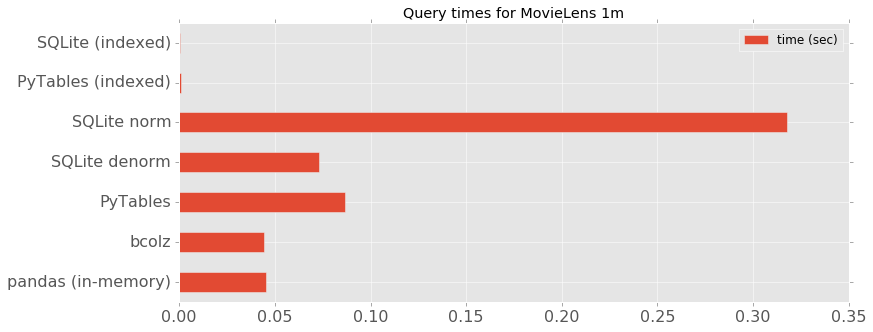

In [50] used -25.066 MiB RAM in 0.229s, peaked 25.809 MiB above current, total RAM usage 401.133 MiB


In [50]:
# Query times
labels = ["pandas (in-memory)", "bcolz", "PyTables", "SQLite denorm", "SQLite norm", "PyTables (indexed)", "SQLite (indexed)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas_mem, qtime_bcolz_opt, qtime_pytables, qtime_sqlite_denorm, qtime_sqlite_norm, qtime_pytables_index2, qtime_sqlite_index1]}, index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m")

## Final size comparison

In [51]:
!du -sh movielens* | sort -n

5.8M	movielens-1m
5.9M	movielens-denorm.bcolz
6.0M	movielens-denorm.h5
9.9M	movielens-indexed.h5
37M	movielens-norm.sqlite
75M	movielens-denorm.sqlite
116M	movielens-indexed.sqlite
In [51] used 0.035 MiB RAM in 0.111s, peaked 0.000 MiB above current, total RAM usage 401.168 MiB


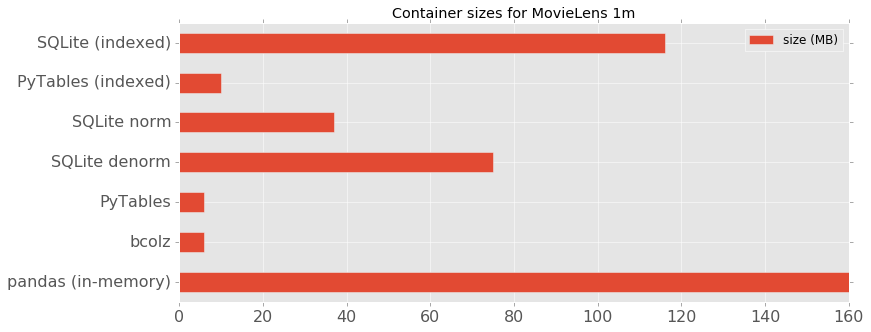

In [52] used 0.543 MiB RAM in 0.205s, peaked 0.000 MiB above current, total RAM usage 401.711 MiB


In [52]:
# Container sizes
df = pd.DataFrame({'size (MB)': [160, 5.9, 6.0, 75, 37, 9.9, 116]}, index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

# Final Overview

Fortunately, there are many different solutions for storing large datasets both in-memory and on-disk.  Here it is a summary of the ones that we have seen in this tutorial:

* In-core
  * Python lists and dictionaries: Included in Python.  Very flexible.  Not efficient for large datasets.
  * NumPy: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * Pandas: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * bcolz: Good for large amounts of data, but reduced functionality.  Supports compression.
  
* Out-of-core
  * bcolz: Good for large datasets.  Supports compression, but not indexing.  Medium query speeds.
  * SQLite: Can be used for large datasets, but requires lots of storage.  Supports indexing.  Excellent query speeds.
  * PyTables: Good for large datasets.  Supports indexing and compression.  Good query speeds.

As you see, every solution has strengths and weaknesses, with wild variations in resource consumptions, so a wise thing to do is to know them better and try to apply the best candidate to your scenario.

As a final note, this series of tutorials is work in progress, so please contact the author in case you see some inacuracy or just want to send feedback.

**Hope you enjoyed the ride!**